In [12]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as ran
import pandas as pd
from scipy.interpolate import interp1d

from matplotlib import rcParams
params = {'legend.fontsize': '16',
         'axes.labelsize': '18',
         'axes.titlesize':'18',
         'xtick.labelsize':'18',
         'ytick.labelsize':'18',
         'font.family': 'sans-serif',
         'text.usetex': True}
rcParams.update(params)
rcParams['text.latex.preamble']= r"\usepackage{bm} \usepackage{amsmath}"

import numpy as np
import matplotlib.pyplot as plt

In [4]:
def fisher_kpp_solver(u0, dt, D, r, K, t_save=[0, 12, 24, 36, 48], dx = 1.0):
    
    """
    Solves the Fisher-KPP equation:
        u_t = D * u_xx + r * u * (1 - u/K)
    with no-flux (Neumann) boundary conditions using explicit Euler time-stepping.

    Parameters:
      u0     : numpy array, initial condition at t=0.
      dt     : time step for the simulation.
      D      : diffusion coefficient.
      r      : growth rate.
      K      : carrying capacity.
      t_save : list of times at which to save the solution (default: [0,12,24,36,48]).
      dx     : spatial step size (default: 1.0).

    Returns:
      saved  : a dictionary mapping times in t_save to the solution numpy array at that time.
      
    """

    u = u0.copy()
    t = 0.0

    # Dictionary for storing the solution at desired times
    saved = {}
    if 0 in t_save:
        saved[0] = u.copy()

    max_time = max(t_save)

    n = len(u) 

    # Time-stepping
    
    while t < max_time:
        print(t, end = '     \r')

        u_new = u.copy()

        # Update interior points using centered finite differences for u_xx
        u_new[1:-1] = u[1:-1] + dt * (
            D * (u[2:] - 2*u[1:-1] + u[:-2]) / (dx**2)
            + r * u[1:-1] * (1 - u[1:-1] / K)
        )

        # Left boundary (i = 0)
        u_new[0] = u[0] + dt * (
            D * (u[1] - 2*u[0] + u[1]) / (dx**2)
            + r * u[0] * (1 - u[0] / K)
        )
        # Right boundary (i = n - 1)
        u_new[-1] = u[-1] + dt * (
            D * (u[-2] - 2*u[-1] + u[-2]) / (dx**2)
            + r * u[-1] * (1 - u[-1] / K)
        )
        
        u = u_new
        t += dt

        # Check if the current time has reached (or passed) one of the save times.
  
        for save_time in t_save:
            if (t - dt < save_time <= t) or np.isclose(t, save_time):
                if save_time not in saved:
                    saved[save_time] = u.copy()

    return saved

In [5]:
times = ['0h', '12h', '24h', '36h', '48h']

# Download data from Jin et al., Journal of Theoretical Biology (2016).

df = [pd.read_excel('1-s2.0-S0022519315005676-mmc2.xlsx', sheet_name = t) for t in times]
xdata = np.array([np.array(np.array(d)[1][1:], dtype = float) for d in df])
dens = np.array([np.array(np.array(d)[-3][1:], dtype = float) for d in df])
stdev = np.array([np.array(np.array(d)[-2][1:], dtype = float) for d in df])

print(np.sum(np.array(df[0])[-4][1:]))

1733.333333333333


/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [18]:
xspan = np.linspace(xdata[0][0],xdata[0][-1],300)
dx = xspan[1] - xspan[0]

ufun = interp1d(xdata[0], dens[0])
u0 = ufun(xspan)


dt = 1e-2
print(dx, dt)
D = 1030       # diffusion coefficient
r = 0.064      # growth rate
K = 1.7*1e-3   # carrying capacity


times_to_save = [0, 12, 24, 36, 48]

# Solve the Fisher-KPP equation

u = fisher_kpp_solver(u0, dt, D, r, K, t_save=times_to_save, dx=dx)


6.187290969899664 0.01


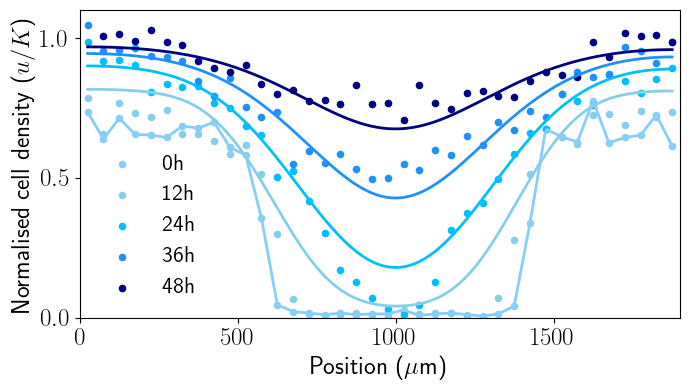

In [19]:
colors = ['lightskyblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'navy']

fig, ax = plt.subplots(1,1, figsize = (7,4))
for i in range(len(times)):
    ax.scatter(xdata[i], dens[i]/K, color = colors[i], marker = 'o', label = times[i], s = 20)
    #ax.errorbar(xdata[i], dens[i], yerr = stdev[i], xerr=None, ecolor=colors[i], elinewidth=1, linestyle = '--', capsize=4, barsabove=True, color = colors[i], marker = 's', markersize = 6)
    ax.plot(xspan, u[int(times[i][:-1])]/K, color = colors[i], lw = 2)

ax.set_ylabel('Normalised cell density ($u/K$) ')
ax.set_xlabel('Position ($\\mu$m)')
ax.set_ylim(0,1.1)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,500,1000,1500])
ax.set_xlim(0,xdata[0][-1] + 25)
ax.legend(frameon = False)

plt.tight_layout()
plt.savefig('figure_scratch_assay.png', transparent = True, dpi = 1200)
plt.show()

In [15]:
xspan = np.linspace(0,200,500)

dx = xspan[1] - xspan[0]


u0 = np.exp(-((xspan/2)**2) / (2 * (10**2)))  # adjust the width as needed



dt = 1e-2
print(dx, dt)
D = 1       # diffusion coefficient
r = .1      # growth rate
K = 1     # carrying capacity


times_to_save = [0,50,100,150]

# Solve the Fisher-KPP equation

u = fisher_kpp_solver(u0, dt, D, r, K, t_save=times_to_save, dx=dx)

0.40080160320641284 0.01


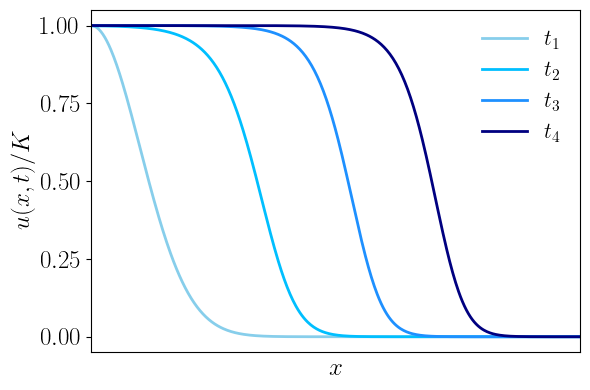

In [16]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
colors = ['lightskyblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'navy']
labels = ['$t_1$', '$t_2$', '$t_3$', '$t_4$']
i = 0
for uu in u.values():

    ax.plot(xspan, uu, color = colors[i + 1], lw = 2, label = labels[i])
    i += 1
ax.set_xticks([])
ax.set_yticks([0,0.25,0.5,0.75,1])

ax.set_xlim(0,200)
ax.legend(frameon = False)
ax.set_ylabel('$u(x,t)/K$ ')
ax.set_xlabel('$x$')

plt.tight_layout()
plt.savefig('fkpp.png', transparent = True, dpi = 1200)

plt.show()